In [1]:
import numpy as np
import random
import gym.spaces as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt



# 1 - (a)

(a) Agent will use the uniform policy, which means that a1 and a2 will be evenly taken by the agent (8%)

In [2]:
# 生成隨機table作為範例
# value = np.zeros((8,3))

# 舉一個例子，取出V(T1)，也就是取出第三列第零行的元素
# v_t1 = value[3,0]

# parameter
prob_action1 = 0.5
prob_action2 = 1 - prob_action1
action1_transform_prob = [[0.2, 0.8], [0.7, 0.3], [0.3, 0.7], [0, 1], [0.2, 0.8]]
action2_transform_prob = [[0.9, 0.1], [0.2, 0.8], [0.7, 0.3], [0, 1], [0.8, 0.2]]
discount_factor = 0.9

# index of each node
S0 = 0
S1 = 1
S2 = 2
T1 = 3
# S3, S4如果要去查action1, 2的表，index要減1
S3 = 4
S4 = 5
T2 = 6
T3 = 7
null_node = 8 # for S3

s_value = 0 # state_value
q_value_a1 = 1 # Q-value-a1
q_value_a2 = 2 # Q-value-a2



# turn left or right, get their prob.
left = 0
right = 1

# (from, to) : reward

reward = {(S0 , S1) : 15, (S0, S2) : 7, (S1, T1) : 7, (S1, S3) : -15, (S2, S3) : -20, 
          (S2, S4) : 5, (S3, null_node) : 0, (S3, T2) : 30, (S4, T2) : 0, (S4, T3) : 10}

In [3]:
def calculate_S_Q_table_a(probability):
    value = np.zeros((8,3))


    check_list = [S4, S3, S2, S1, S0]
    
    each_agent_prob = [] # [S4, S3, S2, S1, S0]
    for prob in probability:
        each_agent_prob.append([prob, 1-prob]) 
        
    
    for i in range(len(check_list)):
        temp = []
        
        prob_action1 = each_agent_prob[i][0]
        prob_action2 = each_agent_prob[i][1]
        
        for key, val in reward.items():
            if key[0] == check_list[i]:
                temp.append(key)
            
        from_node = temp[0][0]
        to1_node = temp[0][1]
        to2_node = temp[1][1]
        
        left_reward = reward[(from_node, to1_node)]
        right_reward = reward[(from_node, to2_node)]
        
    
        if from_node == S4:
            from_node -= 1
            
            # state value
            left_value = prob_action1 * (action1_transform_prob[from_node][left] * (left_reward + discount_factor * value[to1_node, s_value]) +
                            action1_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            right_value = prob_action2 * (action2_transform_prob[from_node][left] * (left_reward + discount_factor * value[to1_node, s_value]) +
                            action2_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            value[from_node + 1, s_value] = left_value + right_value
            
            # q_value_a1
            left_value = action1_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (prob_action1 * value[to1_node, q_value_a1] + prob_action2 * value[to1_node, q_value_a2]))
             
            
            right_value = action1_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node + 1, q_value_a1] = left_value + right_value
            
            
            # q_value_a2
            left_value = action2_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (prob_action1 * value[to1_node, q_value_a1] + prob_action2 * value[to1_node, q_value_a2]))
             
            right_value = action2_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node + 1, q_value_a2] = left_value + right_value
    
        
        elif from_node == S3:
            from_node -= 1
            
            # state value
            left_value = prob_action1 * (action1_transform_prob[from_node][left] * (left_reward + discount_factor * 0) +
                            action1_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            right_value = prob_action2 * (action2_transform_prob[from_node][left] * (left_reward + discount_factor * 0) +
                            action2_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            value[from_node + 1, s_value] = left_value + right_value
            
            # q_value_a1
            left_value = action1_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (0 * 0 + 0 * 0))
             
            
            right_value = action1_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node + 1, q_value_a1] = left_value + right_value
            
            # q_value_a2
            left_value = action2_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (0 * 0 + 0 * 0))
             
            right_value = action2_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node + 1, q_value_a2] = left_value + right_value
        
        else:
            # state value
            left_value = prob_action1 * (action1_transform_prob[from_node][left] * (left_reward + discount_factor * value[to1_node, s_value]) +
                            action1_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            right_value = prob_action2 * (action2_transform_prob[from_node][left] * (left_reward + discount_factor * value[to1_node, s_value]) +
                            action2_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            value[from_node, s_value] = left_value + right_value
            
            # q_value_a1
            left_value = action1_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (prob_action1 * value[to1_node, q_value_a1] + prob_action2 * value[to1_node, q_value_a2]))
             
            
            right_value = action1_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node, q_value_a1] = left_value + right_value
            
             # q_value_a2
            left_value = action2_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (prob_action1 * value[to1_node, q_value_a1] + prob_action2 * value[to1_node, q_value_a2]))
             
            right_value = action2_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node, q_value_a2] = left_value + right_value
    
    return value

uniform_policy = [0.5, 0.5, 0.5, 0.5, 0.5]
S_Q_table_uniform = calculate_S_Q_table_a(uniform_policy)

print('value_a\n' ,S_Q_table_uniform)
# 儲存根據(a)提供的policy計算出的value的array
np.save('value_a.npy',S_Q_table_uniform)

value_a
 [[19.5675 16.295  22.84  ]
 [ 9.75    8.5    11.    ]
 [ 8.25    8.75    7.75  ]
 [ 0.      0.      0.    ]
 [30.     30.     30.    ]
 [ 5.      8.      2.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]]


# 1 - (b)

(b) Agent will use the specific policy which is denoted by π = [PS0, PS1, PS2, PS3, PS4] = [0, 0, 1, 0, 1] where each element represents the probability that the agent will take the action a1, in the other word, one minus that probability denotes the probability that agent will take action a2 (8%)

In [4]:
policy_Pi = [0, 0, 1, 0, 1] # [S0, S1, S2, S3, S4]
# policy_Pi.reverse() # because check_list is [S4, S3, S2, S1, S0]



def calculate_S_Q_table_b(probability):
    value = np.zeros((8,3))
    check_list = [S4, S3, S2, S1, S0]
    reverse_probability = probability[::-1]
    
    each_agent_prob = [] # [S4, S3, S2, S1, S0]
    for prob in reverse_probability:
        each_agent_prob.append([prob, 1-prob]) 
        
    
    for i in range(len(check_list)):
        temp = []
        
        prob_action1 = each_agent_prob[i][0]
        prob_action2 = each_agent_prob[i][1]
        
        for key, val in reward.items():
            if key[0] == check_list[i]:
                temp.append(key)
            
        from_node = temp[0][0]
        to1_node = temp[0][1]
        to2_node = temp[1][1]
        
        left_reward = reward[(from_node, to1_node)]
        right_reward = reward[(from_node, to2_node)]
        
    
        if from_node == S4:
            from_node -= 1
            
            # state value
            left_value = prob_action1 * (action1_transform_prob[from_node][left] * (left_reward + discount_factor * value[to1_node, s_value]) +
                            action1_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            right_value = prob_action2 * (action2_transform_prob[from_node][left] * (left_reward + discount_factor * value[to1_node, s_value]) +
                            action2_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            value[from_node + 1, s_value] = left_value + right_value
            
            # q_value_a1
            # because Pi(a' | s')的s'是terminal，所以再做下一個動作的選擇都為0, a2也是
            prob_action1 = 0
            prob_action2 = 0
                
            left_value = action1_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (prob_action1 * value[to1_node, q_value_a1] + prob_action2 * value[to1_node, q_value_a2]))

            right_value = action1_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node + 1, q_value_a1] = left_value + right_value
            
            
            # q_value_a2

            left_value = action2_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (prob_action1 * value[to1_node, q_value_a1] + prob_action2 * value[to1_node, q_value_a2]))
            
            right_value = action2_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node + 1, q_value_a2] = left_value + right_value
    
        
        elif from_node == S3:
            from_node -= 1
            
            # state value
            left_value = prob_action1 * (action1_transform_prob[from_node][left] * (left_reward + discount_factor * 0) +
                            action1_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            right_value = prob_action2 * (action2_transform_prob[from_node][left] * (left_reward + discount_factor * 0) +
                            action2_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            value[from_node + 1, s_value] = left_value + right_value
            
            # q_value_a1
            # because Pi(a' | s')的s'是terminal，所以再做下一個動作的選擇都為0, a2也是
            prob_action1 = 0
            prob_action2 = 0
            left_value = action1_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (prob_action1 * 0 + prob_action1 * 0))
            
            
            right_value = action1_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node + 1, q_value_a1] = left_value + right_value
            
            # q_value_a2

            left_value = action2_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (prob_action1 * 0 + prob_action1 * 0))
            
            right_value = action2_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node + 1, q_value_a2] = left_value + right_value
        
        else:
            # state value
            left_value = prob_action1 * (action1_transform_prob[from_node][left] * (left_reward + discount_factor * value[to1_node, s_value]) +
                            action1_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            right_value = prob_action2 * (action2_transform_prob[from_node][left] * (left_reward + discount_factor * value[to1_node, s_value]) +
                            action2_transform_prob[from_node][right] * (right_reward + discount_factor * value[to2_node, s_value]))
            
            value[from_node, s_value] = left_value + right_value
            
            # q_value_a1
            if to1_node >= S3:
                prob_action1 = probability[to1_node - 1]
                prob_action2 = 1-prob_action1
            else:
                prob_action1 = probability[to1_node]
                prob_action2 = 1-prob_action1
            left_value = action1_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (prob_action1 * value[to1_node, q_value_a1] + prob_action2 * value[to1_node, q_value_a2]))
             
            if to2_node >= S3:
                prob_action1 = probability[to2_node - 1]
                prob_action2 = 1-prob_action1
            else:
                prob_action1 = probability[to2_node]
                prob_action2 = 1-prob_action1
            right_value = action1_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node, q_value_a1] = left_value + right_value
            
            # q_value_a2
            if to1_node >= S3:
                prob_action1 = probability[to1_node - 1]
                prob_action2 = 1-prob_action1
            else:
                prob_action1 = probability[to1_node]
                prob_action2 = 1-prob_action1
            left_value = action2_transform_prob[from_node][left] * (left_reward + discount_factor * 
                        (prob_action1 * value[to1_node, q_value_a1] + prob_action2 * value[to1_node, q_value_a2]))
             
            if to2_node >= S3:
                prob_action1 = probability[to2_node - 1]
                prob_action2 = 1-prob_action1
            else:
                prob_action1 = probability[to2_node]
                prob_action2 = 1-prob_action1
            right_value = action2_transform_prob[from_node][right] * (right_reward + discount_factor * 
                        (prob_action1 * value[to2_node, q_value_a1] + prob_action2 * value[to2_node, q_value_a2]))
            
            value[from_node, q_value_a2] = left_value + right_value
    
    return value


S_Q_table_finite_MDP = calculate_S_Q_table_b(policy_Pi)

print('value_b\n' ,S_Q_table_finite_MDP)
# 儲存根據(b)提供的policy計算出的value的array
np.save('value_b.npy', S_Q_table_finite_MDP)


value_b
 [[24.0676 18.2408 24.0676]
 [11.      8.5    11.    ]
 [10.64   10.64    8.56  ]
 [ 0.      0.      0.    ]
 [30.     30.     30.    ]
 [ 8.      8.      2.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]]


#2-(a)

In [5]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender==1.0.8 
!pip install box2d-py
from colabgymrender.recorder import Recorder

Requirement already up-to-date: colabgymrender==1.0.8 in /usr/local/lib/python3.7/dist-packages (1.0.8)


In [34]:
class environment():
    def __init__(self):
        self.action_space = sp.Discrete(2)
        self.observation_space = sp.Discrete(8)
        self.s = 0
        self.done = False
        self.transition = {0: [1, 2], 1: [3, 4], 2: [4, 5], 4: [6], 5: [6, 7]}
        self.trans_probability = {0: {0: 0.2, 1: 0.7, 2: 0.3, 4: 1, 5: 0.2},
                                  1: {0: 0.9, 1: 0.2, 2: 0.7, 4: 1, 5: 0.8}}
        self.trans_reward = {0: [15, 7], 1: [7, -15], 2: [-20, 5], 4: [30], 5: [0, 10]}
        self.done_list = [3, 6, 7]
        self.render_state_list = ['S0', 'S1', 'S2', 'T1', 'S3', 'S4', 'T2', 'T3']

    def step(self, a):
        if not self.done:
            s = self.s
            p = self.trans_probability[a][s]
            s_index = 0 if random.random() <= p else 1
            s_ = self.transition[s][s_index]
            r = self.trans_reward[s][s_index]
            d = s_ in self.done_list
            self.s = s_
            self.done = d
            return self.state, r, d, None
        else:
            raise StopIteration('Current environment is done.')

    # 將 class (類) 的方法轉換為 只能讀取的 屬性
    @property
    def state(self):
        s = np.zeros(8)
        s[self.s] = 1
        return s

    # 重新實現一個屬性的 getter,但是背後其實是在操作私有屬性，外人不能直接拿或是改state，封裝特性
    @state.getter
    def state(self):
        s = np.zeros(8)
        s[self.s] = 1

        return s


    def reset(self):
        self.s = 0
        self.done = False
        return self.state

    def render(self):
        print("current state is", self.render_state_list[self.s])
        
        
    def close(self):
        print("TA are very smart, friendly and handsome. peko ><")



In [35]:
# Basic Q-netowrk
class Net(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden):
        super(Net, self).__init__()

        # Two fully-connected layers, input (state) to hidden & hidden to output (action)
        self.fc1 = nn.Linear(n_states, n_hidden)
        self.out = nn.Linear(n_hidden, n_actions)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)  # ReLU activation
        actions_value = self.out(x)
        return actions_value

In [36]:
# Deep Q-Network, composed of one eval network, one target network
class DQN(object):
    def __init__(self, n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity):
        self.eval_net, self.target_net = Net(n_states, n_actions, n_hidden), Net(n_states, n_actions, n_hidden)

        self.memory = np.zeros((memory_capacity, n_states * 2 + 2)) # initialize memory, each memory slot is of size (state + next state + reward + action)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
        self.loss_func = nn.MSELoss()
        self.memory_counter = 0
        self.learn_step_counter = 0 # for target network update, 讓 target network 知道什麼時候要更新

        self.n_states = n_states
        self.n_actions = n_actions
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.lr = lr
        self.epsilon = epsilon
        self.gamma = gamma
        self.target_replace_iter = target_replace_iter
        self.memory_capacity = memory_capacity

    def choose_action(self, state):
        x = torch.unsqueeze(torch.FloatTensor(state), 0)
        current_state = np.argmax(x)
        q_table[current_state] = self.eval_net(x).detach().numpy()[0]

        # epsilon-greedy
        if np.random.random() < self.epsilon: # random
        # if np.random.uniform() < self.epsilon: # random
            action = np.random.randint(0, self.n_actions)
        else: # greedy, 根據現有 policy 做最好的選擇
            actions_value = self.eval_net(x) # feed into eval net, get scores for each action
            action = torch.max(actions_value, 1)[1].data.numpy()[0] # choose the one with the largest score

        return action

    # DQN 需要儲存 experience
    def store_transition(self, state, action, reward, next_state):
        # Pack the experience
        transition = np.hstack((state, [action, reward], next_state))

        # Replace the old memory with new memory
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # Randomly select a batch of memory to learn from
        sample_index = np.random.choice(self.memory_capacity, self.batch_size)
        b_memory = self.memory[sample_index, :]
        b_state = torch.FloatTensor(b_memory[:, :self.n_states])
        b_action = torch.LongTensor(b_memory[:, self.n_states:self.n_states+1].astype(int))
        b_reward = torch.FloatTensor(b_memory[:, self.n_states+1:self.n_states+2])
        b_next_state = torch.FloatTensor(b_memory[:, -self.n_states:])

        # Compute loss between Q values of eval net & target net, forward propagation
        q_eval = self.eval_net(b_state).gather(1, b_action) # evaluate the Q values of the experiences, given the states & actions taken at that time
        q_next = self.target_net(b_next_state).detach() # detach from graph, don't backpropagate
        q_target = b_reward + self.gamma * q_next.max(1)[0].view(self.batch_size, 1) # compute the target Q values
        loss = self.loss_func(q_eval, q_target) # loss between eval_net and target_net

        # Backpropagation
        # refer to : https://meetonfriday.com/posts/18392404/
        self.optimizer.zero_grad() # 清空前一次的gradient
        loss.backward()            # 根據loss進行back propagation，計算gradient
        self.optimizer.step()      # 做gradient descent

        # Update target network every few iterations (target_replace_iter), i.e. replace target net with eval net
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_replace_iter == 0: # accumulate 100 iteration, and replace target net with eval net
            self.target_net.load_state_dict(self.eval_net.state_dict())

In [40]:
# Hyper parameters 1
n_hidden = 50
batch_size = 32
lr = 0.01                 # learning rate
epsilon = 0.1             # epsilon-greedy, factor to explore randomly
gamma = 0.9               # reward discount factor
target_replace_iter = 100 # target network update frequency
memory_capacity = 2000
n_episodes = 2000 # epoch

# # Hyper parameters 2
# n_hidden = 50
# batch_size = 32
# lr = 0.0001                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99               # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 2000
# n_episodes = 10000 # epoch

# # Hyper parameters 3
# n_hidden = 50
# batch_size = 32
# lr = 0.0001                 # learning rate
# epsilon = 0.1               # epsilon-greedy, factor to explore randomly
# gamma = 0.99                # reward discount factor
# target_replace_iter = 100   # target network update frequency
# memory_capacity = 2000
# n_episodes = 2000 # epoch

# # Hyper parameters 4
# n_hidden = 50
# batch_size = 128
# lr = 0.0001                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99               # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 2000
# n_episodes = 3000 # epoch

In [41]:
# training
# 1. 選擇 action 2. 儲存 experience 3. 訓練

# Cheating mode speeds up the training process
# CHEAT = False

q_table = np.zeros((8, 2))
env = environment()

# Environment parameters
n_actions = 2
n_states = 8




reward_process_Finite_MDP = []
# Create DQN
dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

# Collect experience
for i_episode in range(n_episodes):
    t = 0 # timestep
    rewards = 0 # accumulate rewards for each episode
    state = env.reset() # reset environment to initial state for each episode ###issue:where to call reset(), no reset in MDP_env
    while True:
        # env.render() # check current state

        # Agent takes action
        action = dqn.choose_action(state) # choose an action based on DQN
        next_state, reward, done, info = env.step(action) # do the action, get the reward

        # Cheating part: modify the reward to speed up training process
        # if CHEAT:
        #     x, v, theta, omega = next_state
        #     r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8 # reward 1: the closer the cart is to the center, the better
        #     r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5 # reward 2: the closer the pole is to the center, the better
        #     reward = r1 + r2

        # Keep the experience in memory
        dqn.store_transition(state, action, reward, next_state)

        # Accumulate reward
        rewards += reward

        # If enough memory stored, agent learns from them via Q-learning
        if dqn.memory_counter > memory_capacity:
            dqn.learn()

        # Transition to next state
        state = next_state

        if done:
            print('Episode {} finished after {} timesteps, total rewards {}'.format(i_episode + 1, t+1, rewards))
            break

        t += 1
    reward_process_Finite_MDP.append(rewards)
env.close()


Episode 1 finished after 2 timesteps, total rewards 22
Episode 2 finished after 2 timesteps, total rewards 22
Episode 3 finished after 3 timesteps, total rewards 17
Episode 4 finished after 3 timesteps, total rewards 22
Episode 5 finished after 3 timesteps, total rewards 17
Episode 6 finished after 3 timesteps, total rewards 22
Episode 7 finished after 3 timesteps, total rewards 22
Episode 8 finished after 2 timesteps, total rewards 22
Episode 9 finished after 3 timesteps, total rewards 22
Episode 10 finished after 3 timesteps, total rewards 17
Episode 11 finished after 3 timesteps, total rewards 22
Episode 12 finished after 3 timesteps, total rewards 17
Episode 13 finished after 3 timesteps, total rewards 22
Episode 14 finished after 3 timesteps, total rewards 22
Episode 15 finished after 3 timesteps, total rewards 22
Episode 16 finished after 3 timesteps, total rewards 30
Episode 17 finished after 3 timesteps, total rewards 17
Episode 18 finished after 3 timesteps, total rewards 17
E

# 2-(b)

Please analyze the difference between your answers by the calculation and the output of the DQN (8%)


自己算的value並沒有經過learning，

而DQN經過learning，隨著epoch越大，NN會學習到如何在state下依照action去選擇怎麼走，所以累加的reward會越來越大，
那算出來的q_value就會越大。

可以看到uniform跟finite_MDP其實差不多，不管是q_value or state value，但是DQN的q_value就很明顯大很多。

In [12]:
# This S_Q_table is from uniform policy
print(S_Q_table_uniform)

[[19.5675 16.295  22.84  ]
 [ 9.75    8.5    11.    ]
 [ 8.25    8.75    7.75  ]
 [ 0.      0.      0.    ]
 [30.     30.     30.    ]
 [ 5.      8.      2.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]]


In [13]:
# This S_Q_table is from finite_MDP_env
print(S_Q_table_finite_MDP)

[[24.0676 18.2408 24.0676]
 [11.      8.5    11.    ]
 [10.64   10.64    8.56  ]
 [ 0.      0.      0.    ]
 [30.     30.     30.    ]
 [ 8.      8.      2.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]]


In [14]:
# This Q_table is from DQN
state_value_list = []

# epsilon = 0.1
# 0.1 * random choose action + 0.9 * max(q_value)
# random choose action = (0.5 * q_value1 + 0.5 * q_value2)

for i in range(len(q_table)):
    state_value = 0.1 * (0.5 * q_table[i][0] + 0.5 * q_table[i][1]) + 0.9 * (max(q_table[i]))
    state_value_list.append(state_value)

state_value_list = np.array([state_value_list])
S_Q_table_DQN = np.concatenate((state_value_list.T, q_table), axis=1)

print(S_Q_table_DQN)


[[35.65324993 36.22003937 24.88425064]
 [25.74616604 26.1677742  17.73561096]
 [27.86637011 28.39358521 17.84928322]
 [ 0.          0.          0.        ]
 [38.33988838 38.98547363 26.07376862]
 [28.43868256 28.90994835 19.48463249]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


#3-(a)


In [43]:
# Deep Q-Network, composed of one eval network, one target network
class DQN(object):
    def __init__(self, n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity):
        self.eval_net, self.target_net = Net(n_states, n_actions, n_hidden), Net(n_states, n_actions, n_hidden)

        self.memory = np.zeros((memory_capacity, n_states * 2 + 2)) # initialize memory, each memory slot is of size (state + next state + reward + action)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
        self.loss_func = nn.MSELoss()
        self.memory_counter = 0
        self.learn_step_counter = 0 # for target network update, 讓 target network 知道什麼時候要更新

        self.n_states = n_states
        self.n_actions = n_actions
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.lr = lr
        self.epsilon = epsilon
        self.gamma = gamma
        self.target_replace_iter = target_replace_iter
        self.memory_capacity = memory_capacity

    def choose_action(self, state):
        x = torch.unsqueeze(torch.FloatTensor(state), 0) # 把state還原成原本的型式
        
        # epsilon-greedy
        if np.random.random() < self.epsilon: # random
        # if np.random.uniform() < self.epsilon: # random
            action = np.random.randint(0, self.n_actions)
        else: # greedy, 根據現有 policy 做最好的選擇
            actions_value = self.eval_net(x) # feed into eval net, get scores for each action
            action = torch.max(actions_value, 1)[1].data.numpy()[0] # choose the one with the largest score
            
            
            
        return action

    # DQN 需要儲存 experience
    def store_transition(self, state, action, reward, next_state):
        # Pack the experience
        transition = np.hstack((state, [action, reward], next_state))

        # Replace the old memory with new memory
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # Randomly select a batch of memory to learn from
        sample_index = np.random.choice(self.memory_capacity, self.batch_size)
        b_memory = self.memory[sample_index, :]
        b_state = torch.FloatTensor(b_memory[:, :self.n_states])
        b_action = torch.LongTensor(b_memory[:, self.n_states:self.n_states+1].astype(int))
        b_reward = torch.FloatTensor(b_memory[:, self.n_states+1:self.n_states+2])
        b_next_state = torch.FloatTensor(b_memory[:, -self.n_states:])

        # Compute loss between Q values of eval net & target net, forward propagation
        q_eval = self.eval_net(b_state).gather(1, b_action) # evaluate the Q values of the experiences, given the states & actions taken at that time
        q_next = self.target_net(b_next_state).detach() # detach from graph, don't backpropagate
        q_target = b_reward + self.gamma * q_next.max(1)[0].view(self.batch_size, 1) # compute the target Q values
        loss = self.loss_func(q_eval, q_target) # loss between eval_net and target_net

        # Backpropagation
        # refer to : https://meetonfriday.com/posts/18392404/
        self.optimizer.zero_grad() # 清空前一次的gradient
        loss.backward()            # 根據loss進行back propagation，計算gradient
        self.optimizer.step()      # 做gradient descent

        # Update target network every few iterations (target_replace_iter), i.e. replace target net with eval net
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_replace_iter == 0: # accumulate 100 iteration, and replace target net with eval net
            self.target_net.load_state_dict(self.eval_net.state_dict())




In [44]:
env = gym.make('LunarLander-v2')
directory = './video'
env = Recorder(env, directory)
env.seed(0)
print('State shape:',env.observation_space.shape[0])
print('Number of actions:',env.action_space.n)

[0]

State shape: 8
Number of actions: 4


In [54]:
# # Hyper parameters 1
# n_hidden = 50
# batch_size = 32
# lr = 0.01                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.9               # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 2000
# n_episodes = 300 # epoch

# # Hyper parameters 2
# n_hidden = 50
# batch_size = 32
# lr = 0.0001                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99               # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 2000
# n_episodes = 1000 # epoch

# # Hyper parameters 3
# n_hidden = 50
# batch_size = 128
# lr = 0.00001                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99               # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 2000
# n_episodes = 300 # epoch

# # Hyper parameters 4
# n_hidden = 128
# batch_size = 32
# lr = 0.00001                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99              # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 2000
# n_episodes = 300 # epoch



# # Hyper parameters 5
# n_hidden = 128
# batch_size = 32
# lr = 0.0005                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99              # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 500
# n_episodes = 300 # epoch

# # Hyper parameters 6
# n_hidden = 64
# batch_size = 32
# lr = 0.0001                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99              # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 1000
# n_episodes = 300 # epoch

# # Hyper parameters 7
# n_hidden = 64
# batch_size = 64
# lr = 0.005                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99              # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 1500
# n_episodes = 300 # epoch

# Hyper parameters 8
n_hidden = 64
batch_size = 32
lr = 0.001                 # learning rate
epsilon = 0.1             # epsilon-greedy, factor to explore randomly
gamma = 0.99              # reward discount factor
target_replace_iter = 100 # target network update frequency
memory_capacity = 2000
n_episodes = 300 # epoch



In [55]:


# Environment parameters
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]





# Create DQN
dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)


reward_process_LunarLander = []

# Collect experience
for i_episode in range(n_episodes):
    t = 0 # timestep
    rewards = 0 # accumulate rewards for each episode
    state = env.reset() # reset environment to initial state for each episode ###issue:where to call reset(), no reset in MDP_env
    while True:
        # env.render() # check current state

        # Agent takes action
        action = dqn.choose_action(state) # choose an action based on DQN
        next_state, reward, done, info = env.step(action) # do the action, get the reward

        # Cheating part: modify the reward to speed up training process
        # if CHEAT:
        #     x, v, theta, omega = next_state
        #     r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8 # reward 1: the closer the cart is to the center, the better
        #     r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5 # reward 2: the closer the pole is to the center, the better
        #     reward = r1 + r2

        # Keep the experience in memory
        dqn.store_transition(state, action, reward, next_state)

        # Accumulate reward
        rewards += reward
        

        # If enough memory stored, agent learns from them via Q-learning
        if dqn.memory_counter > memory_capacity:
            dqn.learn()

        # Transition to next state
        state = next_state

        if done:
            print('Episode {} finished after {} timesteps, total rewards {}'.format(i_episode + 1, t+1, rewards))
            break

        t += 1
    reward_process_LunarLander.append(rewards)
    # env.play()
env.close()


Episode 1 finished after 78 timesteps, total rewards -164.65326706465777
Episode 2 finished after 86 timesteps, total rewards -136.45992657528615
Episode 3 finished after 85 timesteps, total rewards -159.82210572822908
Episode 4 finished after 91 timesteps, total rewards -130.28412681945917
Episode 5 finished after 95 timesteps, total rewards -204.31305544339273
Episode 6 finished after 81 timesteps, total rewards -171.11500226557575
Episode 7 finished after 64 timesteps, total rewards -144.22928337856683
Episode 8 finished after 68 timesteps, total rewards -163.56726473194644
Episode 9 finished after 81 timesteps, total rewards -163.63436141910023
Episode 10 finished after 61 timesteps, total rewards -145.6248978812206
Episode 11 finished after 89 timesteps, total rewards -112.14997831688645
Episode 12 finished after 89 timesteps, total rewards -115.42261357293788
Episode 13 finished after 91 timesteps, total rewards -111.44673586141155
Episode 14 finished after 74 timesteps, total re

# 3 - (a)

(a) Please compare the difference between the total return curves of the previous finite MDP and the LunarLander-v2 environment. (8%)

Text(0, 0.5, 'reward')

Text(0.5, 0, 'Episode #')

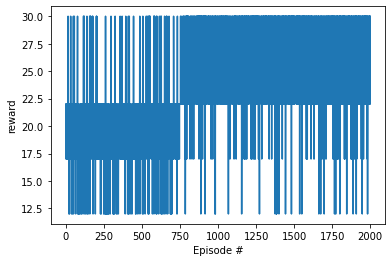

In [42]:
# Hyper parameters 1
n_hidden = 50
batch_size = 32
lr = 0.01                 # learning rate
epsilon = 0.1             # epsilon-greedy, factor to explore randomly
gamma = 0.9               # reward discount factor
target_replace_iter = 100 # target network update frequency
memory_capacity = 2000
n_episodes = 2000 # epoch

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(reward_process_Finite_MDP)), reward_process_Finite_MDP)
plt.ylabel('reward')
plt.xlabel('Episode #')
plt.show()

Text(0, 0.5, 'reward')

Text(0.5, 0, 'Episode #')

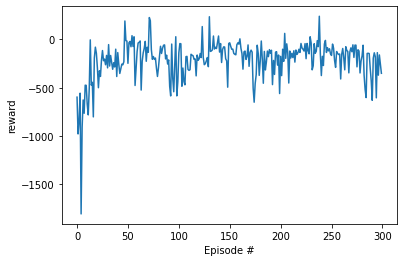

In [28]:
# Hyper parameters 1
# n_hidden = 50
# batch_size = 32
# lr = 0.01                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.9               # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 2000
# n_episodes = 300 # epoch

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(reward_process_LunarLander)), reward_process_LunarLander)
plt.ylabel('reward')
plt.xlabel('Episode #')
plt.show()

# 3 - (b)

(b) Please choose some hyper-parameters and analyze how these hyper-parameters affect the training result. (8%)


技術上的困難：

因為在Colab上面沒有成功轉成GPU的模式及跑法，to.device()可能有些地方有錯，
所以在訓練時epoch無法跑太大，要花太多時間。

結論：

因為epoch跑不了太大，我參考其他同學的epoch，他們都有跑超過1000，
訓練的效果在超過400 ~ 500 epoch之後才有比較穩定的reward表現，reward才有較高的機率大於0。

接下來聊聊其他的參數：

learning rate：

影響的是收斂速度，所以在這邊我的目標是做0.01 ~ 0.00001的比較，間隔是5倍。
那0.01的收斂效果理論上要比較好，可能應為epoch不大，所以還沒觀察到。

number_hidden:

是NN內全連接的神經元數，看執行時間是會影響跑code的快慢。


epsilon：

這邊沒做調整





Text(0, 0.5, 'reward')

Text(0.5, 0, 'Episode #')

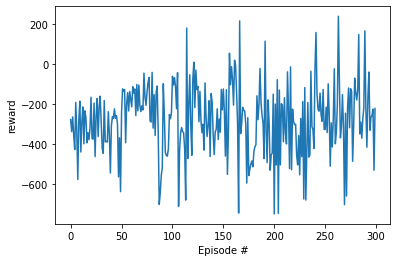

In [21]:
# # Hyper parameters 3
# n_hidden = 50
# batch_size = 128
# lr = 0.00001                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99               # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 2000
# n_episodes = 300 # epoch

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(reward_process_LunarLander)), reward_process_LunarLander)
plt.ylabel('reward')
plt.xlabel('Episode #')
plt.show()

Text(0, 0.5, 'reward')

Text(0.5, 0, 'Episode #')

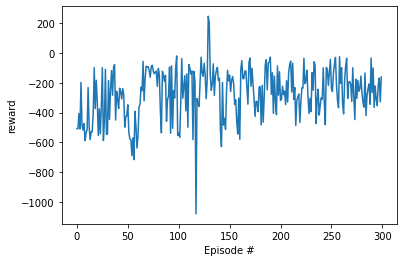

In [25]:
# Hyper parameters 4
n_hidden = 128
batch_size = 32
lr = 0.00001                 # learning rate
epsilon = 0.1             # epsilon-greedy, factor to explore randomly
gamma = 0.99              # reward discount factor
target_replace_iter = 100 # target network update frequency
memory_capacity = 2000
n_episodes = 300 # epoch

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(reward_process_LunarLander)), reward_process_LunarLander)
plt.ylabel('reward')
plt.xlabel('Episode #')
plt.show()

Text(0, 0.5, 'reward')

Text(0.5, 0, 'Episode #')

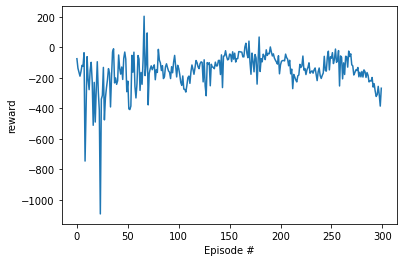

In [47]:
# Hyper parameters 5
n_hidden = 128
batch_size = 32
lr = 0.0005                 # learning rate
epsilon = 0.1             # epsilon-greedy, factor to explore randomly
gamma = 0.99              # reward discount factor
target_replace_iter = 100 # target network update frequency
memory_capacity = 500
n_episodes = 300 # epoch

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(reward_process_LunarLander)), reward_process_LunarLander)
plt.ylabel('reward')
plt.xlabel('Episode #')
plt.show()

Text(0, 0.5, 'reward')

Text(0.5, 0, 'Episode #')

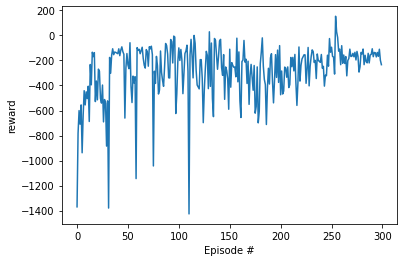

In [50]:
# # Hyper parameters 6
# n_hidden = 64
# batch_size = 32
# lr = 0.0001                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99              # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 1000
# n_episodes = 300 # epoch

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(reward_process_LunarLander)), reward_process_LunarLander)
plt.ylabel('reward')
plt.xlabel('Episode #')
plt.show()

Text(0, 0.5, 'reward')

Text(0.5, 0, 'Episode #')

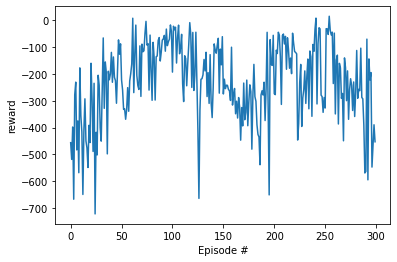

In [53]:
# # Hyper parameters 7
# n_hidden = 64
# batch_size = 64
# lr = 0.005                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99              # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 1500
# n_episodes = 300 # epoch

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(reward_process_LunarLander)), reward_process_LunarLander)
plt.ylabel('reward')
plt.xlabel('Episode #')
plt.show()

Text(0, 0.5, 'reward')

Text(0.5, 0, 'Episode #')

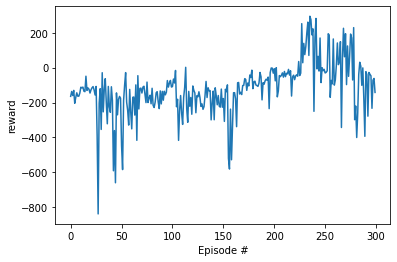

In [56]:
# # Hyper parameters 8
# n_hidden = 64
# batch_size = 32
# lr = 0.001                 # learning rate
# epsilon = 0.1             # epsilon-greedy, factor to explore randomly
# gamma = 0.99              # reward discount factor
# target_replace_iter = 100 # target network update frequency
# memory_capacity = 2000
# n_episodes = 300 # epoch


# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(reward_process_LunarLander)), reward_process_LunarLander)
plt.ylabel('reward')
plt.xlabel('Episode #')
plt.show()

#try another DQN implement


to do ...

I didn't finish this part.
So, TA can pass it.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,n_actions):
        super(DeepQNetwork, self).__init__()
        # print("input_dims ", input_dims[0], " n_actions ",n_actions)
        self.input_dims = input_dims[0]+n_actions
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = 1
        self.fc1 = nn.Linear(self.input_dims,self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims,self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims,self.n_actions)
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.loss = nn.MSELoss()
        if torch.cuda.is_available():
            print("Using CUDA")
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cuda:1')

        # print("Cuda device ",self.device)
        self.to(self.device)

    def forward(self,state_action):
        #action to 1 hot
        # action_1hot = np.zeros(self.n_actions)
        # action_1hot[action] = 1.0
        # observation_state = np.append(observation,action_1hot)
        state = torch.Tensor(state_action).to(self.device)
        x = F.relu(self.fc1(state))
        x = F.relu((self.fc2(x)))
        predicted_Q_value = self.fc3(x)
        return predicted_Q_value


class Agent(object):
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                max_mem_size=100000, eps_end=0.01, eps_dec=0.996):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_end = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.n_actions = n_actions
        # print("input_dims ", input_dims)
        self.input_dims = input_dims[0]
        self.batch_size = batch_size
        self.action_space = [i for i in range(n_actions)]
        self.max_mem_size = max_mem_size
        self.mem_counter = 0
        self.Q_eval = DeepQNetwork(lr=lr,n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)
        self.state_memory = np.zeros((self.max_mem_size,self.input_dims))
        self.new_state_memory = np.zeros((self.max_mem_size,self.input_dims))
        self.action_memory = np.zeros((self.max_mem_size,n_actions))
        self.action_state_memory = np.zeros((self.max_mem_size,self.input_dims+n_actions))
        self.reward_memory = np.zeros(self.max_mem_size)
        self.Q_memory = np.zeros(self.max_mem_size)
        self.terminal_memory = np.zeros(self.max_mem_size)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_counter % self.max_mem_size
        self.state_memory[index] = state
        actions = np.zeros(self.n_actions)
        actions[action] = 1.0
        self.action_memory[index] = actions
        self.reward_memory[index] = reward
        self.terminal_memory[index] = terminal
        self.new_state_memory[index] = state_
        self.action_state_memory[index] = np.append(state,actions)
        self.mem_counter+=1

    def calculate_bellman(self,episode_len):
        for i in range(episode_len):
            index = ((self.mem_counter-1)-i) % self.max_mem_size
            next_index = ((self.mem_counter)-i) % self.max_mem_size
            if i==0:
                self.Q_memory[index] = self.reward_memory[index]
                # print("last Q ", self.Q_memory[index])
            else:
                self.Q_memory[index] = self.reward_memory[index] + self.gamma * self.Q_memory[next_index]
                # print("Q ", self.Q_memory[index])

    def update_epsilon(self):
        self.epsilon = self.epsilon * self.eps_dec if self.epsilon > self.eps_end else self.eps_end

    def process_end_of_episode(self,episode_len):
        self.calculate_bellman(episode_len)
        self.update_epsilon()

    def choose_action(self, observation):
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            estimated_Q_values = torch.Tensor( np.zeros(self.n_actions)).to(self.Q_eval.device)
            for i in range (self.n_actions):
                action_1hot = np.zeros(self.n_actions)
                action_1hot[i] = 1.0
                # print("about to evaulate action ",i, " array of action ", action_1hot," with observation",  observation[:10])
                # print("concatanated sate action vector ", np.append(observation,action_1hot) )
                estimated_Q_values[i] = self.Q_eval.forward(  np.append(observation,action_1hot)  )


            # actions = self.Q_eval.forward(observation)

            # print("estimated Q values", estimated_Q_values)
            action = torch.argmax(estimated_Q_values).item()
        return action

    def learn(self, step_counter):
        if self.mem_counter > self.batch_size:
            self.Q_eval.optimizer.zero_grad()
            max_mem = self.mem_counter if self.mem_counter < self.max_mem_size else self.max_mem_size
            batch = np.random.choice(max_mem,self.batch_size)
            #print("batch size", batch.size())
            state_batch = self.state_memory[batch]
            action_batch = self.action_memory[batch]
            action_values = np.array(self.action_space, dtype=np.uint8)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = self.reward_memory[batch]
            q_batch = self.Q_memory[batch]
            terminal_batch = self.terminal_memory[batch]
            new_state_batch = self.new_state_memory[batch]
            action_state_batch = self.action_state_memory[batch]

            reward_batch = torch.Tensor(reward_batch).to(self.Q_eval.device)
            terminal_batch = torch.Tensor(terminal_batch).to(self.Q_eval.device)

            q_eval = self.Q_eval.forward(action_state_batch).to(self.Q_eval.device)
            q_target = torch.Tensor(q_batch).to(self.Q_eval.device)
            # q_next = self.Q_eval.forward(new_state_batch).to(self.Q_eval.device)

            # batch_index = np.arange(self.batch_size, dtype=np.int32)
            # q_target[action_batch] = reward_batch  + self.gamma*torch.max(q_next, dim=1)[0]*terminal_batch

            # self.epsilon = self.epsilon * self.eps_dec if self.epsilon > self.eps_end else self.eps_end
            # if (step_counter%50)==49:
            #     print("Q eval ",q_eval, "q target", q_target)
            loss = self.Q_eval.loss(q_eval,q_target)
            loss.backward()
            self.Q_eval.optimizer.step()
print(torch.cuda.is_available())

In [ ]:
import gym
from DQN_torch import Agent
# from utils import plotLearning
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


env=gym.make('LunarLander-v2')
brain = Agent(gamma=0.98, epsilon=0.7, batch_size=2, n_actions=4,
            input_dims=[8], lr=0.01, eps_end=0.02,eps_dec=0.992)
scores = []
eps_history = []
n_games = 50000
score = 0

for i in range (n_games):
    if i%10 == 0 and i>0 and i>10:
        avg_score = np.mean(scores[:-10])
        print('epside ', i, 'score', score,
        'average score %3f' % avg_score,
        'epsilon %3f' % brain.epsilon)
    else:
        print('episode ',i, 'score', score)
    score = 0

    eps_history.append(brain.epsilon)
    observation = env.reset()
    done = False
    step_counter = 0
    while not done:
        env.render()
        action = brain.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        # print("chosen action after chose action ", action)
        score+=reward
        brain.store_transition(observation,action, reward, observation_,done)
        if i>5:
            brain.learn(step_counter)
        observation = observation_
        step_counter += 1
    # EPISODE done
    # "CALCULATE BELL MAN IN AGENT CLASS brain.compute_reward()"
    brain.process_end_of_episode(step_counter)
    scores.append(score)

# x = [i+1 for i in range(n_games)]
# filename = 'lunar-lander.png'
# plotLearning(x, scores, eps_history, filename,)